In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,Concatenate ,Dropout ,Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D,AveragePooling2D,Conv2DTranspose, Input, Concatenate, Add, BatchNormalization, Activation, MultiHeadAttention
from ipywidgets import IntProgress
from IPython.display import display
import os
import cv2
import PIL
import PIL.Image
import json
import random
from random import randint as rand
from os import listdir
from os.path import isfile, join
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

[]


In [2]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
num_layers_to_keep = 120
output_tensor = base_model.layers[num_layers_to_keep - 1].output
adaptive_pool_output = tf.keras.layers.Resizing(7, 7, interpolation='bilinear')(output_tensor)
adaptive_max_pool_output = tf.keras.layers.MaxPool2D(pool_size=(2,2))(output_tensor)
output_tensor = Concatenate(axis=-1)([adaptive_max_pool_output, adaptive_pool_output])
clipped_model = tf.keras.Model(inputs=base_model.input, outputs=output_tensor)
for layer in clipped_model.layers[:-30]:
    layer.trainable = False
for layer in clipped_model.layers[-30:]:
    layer.trainable = True

clipped_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 616,256 (2.35 MB)

 Trainable params: 334,272 (1.28 MB)

 Non-trainable params: 281,984 (1.08 MB)

In [3]:
import os
import random
import tensorflow as tf
import numpy as np

fixed_num_boxes = 20  
image_height, image_width = 224, 224

def preprocess_image(path):
    raw = tf.io.read_file(path)
    img = tf.image.decode_jpeg(raw, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

import tensorflow as tf
import numpy as np

def generate_void_boxes(boxes_tensor, n_void=2, img_size=(224, 224)):
   
    boxes = boxes_tensor.numpy()
    img_w, img_h = img_size
    
    if len(boxes) > 0:
        ws, hs = boxes[:, 2], boxes[:, 3]
        min_w, max_w = np.min(ws) // 3, np.max(ws) * 1.5
        min_h, max_h = np.min(hs) // 3, np.max(hs) * 1.5
        
       
        gt_x1 = boxes[:, 0] 
        gt_y1 = boxes[:, 1] 
        gt_x2 = boxes[:, 2] 
        gt_y2 = boxes[:, 3] 
    else:
        base_size = min(img_w, img_h) * 0.2
        min_w, max_w = base_size * 0.5, base_size * 2.0
        min_h, max_h = base_size * 0.5, base_size * 2.0
        gt_x1, gt_y1, gt_x2, gt_y2 = [], [], [], []

    max_w = min(max_w, img_w)
    max_h = min(max_h, img_h)

    void_boxes = []
    max_attempts = 200 
    
    for _ in range(n_void):
        for _ in range(max_attempts):
            w = np.random.uniform(max(10, min_w), max_w)
            h = np.random.uniform(max(10, min_h), max_h)
            
            if img_w - w <= 0 or img_h - h <= 0: continue
            cx = np.random.uniform(w/2, img_w - w/2)
            cy = np.random.uniform(h/2, img_h - h/2)
            
            cand_x1 = cx - w/2
            cand_y1 = cy - h/2
            cand_x2 = cx + w/2
            cand_y2 = cy + h/2
            
            if len(boxes) == 0:
                void_boxes.append([cand_x1, cand_y1, cand_x2, cand_y2])
                break 
                
            ix1 = np.maximum(gt_x1, cand_x1)
            iy1 = np.maximum(gt_y1, cand_y1)
            ix2 = np.minimum(gt_x2, cand_x2)
            iy2 = np.minimum(gt_y2, cand_y2)
            
            i_w = np.maximum(0.0, ix2 - ix1)
            i_h = np.maximum(0.0, iy2 - iy1)
            inter_area = i_w * i_h
            
            if np.any(inter_area > 1.0): 
                continue 
            
            void_boxes.append([cand_x1, cand_y1, cand_x2, cand_y2])
            break 
                
    if not void_boxes:
        return tf.zeros((0, 4), dtype=tf.float32)
        
    return tf.convert_to_tensor(void_boxes, dtype=tf.float32)




import os
import random
import tensorflow as tf
import numpy as np

import os
import random
import tensorflow as tf
import numpy as np


def generator():
    annotations_path = 'PPE.v14i.yolokeras\\update__annotations.txt'
    
    with open(annotations_path, 'r') as f:
        image_paths = [line.strip() for line in f.readlines() if line.strip()]
    
    for image_path in image_paths:
        full_image_path = image_path
        
        label_path = os.path.join(
            'PPE.v14i.yolokeras\\train\\labels',
            os.path.basename(image_path) + '.txt'
        )
        
        try:
            image = preprocess_image(full_image_path)
            image = tf.image.resize(image, (224, 224))
            
            rotation = random.choice([0, 1, 2, 3])
            rotated_image = image 
            
        except:
            continue  
        
        boxes = []
        classes = []
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    line = line.strip()
                    if not line: continue
                    
                    parts = line.split()
                    class_id = int(parts[0]) 
                    
                    x, y = float(parts[1]) * 224, float(parts[2]) * 224
                    w, h = float(parts[3]) * 224, float(parts[4]) * 224
                    
                    boxes.append([x, y, w, h])
                    classes.append([class_id])
        
        if boxes:
            gt_boxes_tensor = tf.convert_to_tensor(boxes, dtype=tf.float32)
        else:
            gt_boxes_tensor = tf.zeros((0, 4), dtype=tf.float32)

        void_boxes = generate_void_boxes(gt_boxes_tensor, n_void=1)
        
        if void_boxes is not None and tf.shape(void_boxes)[0] > 0:
            void_list = void_boxes.numpy().tolist()
            boxes.extend(void_list)
            
      
            classes.extend([[-1]] * len(void_list))
        
        if len(boxes) > fixed_num_boxes:
            boxes = boxes[:fixed_num_boxes]
            classes = classes[:fixed_num_boxes]
        elif len(boxes) < fixed_num_boxes:
            pad_size = fixed_num_boxes - len(boxes)
            boxes.extend([[0, 0, 0, 0]] * pad_size)
            
            # ВАЖНО: Паддинг тоже обозначаем -1
            classes.extend([[-1]] * pad_size)
        
        boxes_tensor = tf.convert_to_tensor(boxes, dtype=tf.float32)
        classes_tensor = tf.convert_to_tensor(classes, dtype=tf.int32)
        
        yield rotated_image, boxes_tensor, classes_tensor

dataset = tf.data.Dataset.from_generator(
    generator, 
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(fixed_num_boxes, 4), dtype=tf.float32),
        tf.TensorSpec(shape=(fixed_num_boxes, 1), dtype=tf.int32)
    )
)
dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(50)


def valid_generator():
    annotations_path = 'PPE.v14i.yolokeras\\update_test_annotations.txt'
    
    with open(annotations_path, 'r') as f:
        image_paths = [line.strip() for line in f.readlines() if line.strip()]
    
    for image_path in image_paths:
        full_image_path = image_path
        
        label_path = os.path.join(
            'PPE.v14i.yolokeras\\test\\labels',
            os.path.basename(image_path) + '.txt'
        )
        
        try:
            image = preprocess_image(full_image_path)
            image = tf.image.resize(image, (224, 224))
            rotated_image = image
        except:
            continue  
        
        boxes = []
        classes = []
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    line = line.strip()
                    if not line: continue
                    parts = line.split()
                    class_id = int(parts[0])
                    x, y = float(parts[1]) * 224, float(parts[2]) * 224
                    w, h = float(parts[3]) * 224, float(parts[4]) * 224
                    boxes.append([x, y, w, h])
                    classes.append([class_id])
        
        if boxes:
            gt_boxes_tensor = tf.convert_to_tensor(boxes, dtype=tf.float32)
        else:
            gt_boxes_tensor = tf.zeros((0, 4), dtype=tf.float32)

        void_boxes = generate_void_boxes(gt_boxes_tensor, n_void=1)
        
        if void_boxes is not None and tf.shape(void_boxes)[0] > 0:
            void_list = void_boxes.numpy().tolist()
            boxes.extend(void_list)
            classes.extend([[-1]] * len(void_list))
        
        if len(boxes) > fixed_num_boxes:
            boxes = boxes[:fixed_num_boxes]
            classes = classes[:fixed_num_boxes]
        elif len(boxes) < fixed_num_boxes:
            pad_size = fixed_num_boxes - len(boxes)
            boxes.extend([[0, 0, 0, 0]] * pad_size)
            # ПАДДИНГ -> -1
            classes.extend([[-1]] * pad_size)
        
        boxes_tensor = tf.convert_to_tensor(boxes, dtype=tf.float32)
        classes_tensor = tf.convert_to_tensor(classes, dtype=tf.int32)
        
        yield rotated_image, boxes_tensor, classes_tensor

valid_dataset = tf.data.Dataset.from_generator(
    valid_generator, 
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(fixed_num_boxes, 4), dtype=tf.float32),
        tf.TensorSpec(shape=(fixed_num_boxes, 1), dtype=tf.int32)
    )
)
valid_dataset = valid_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)



In [4]:
inputs = Input(( 3, 3, 1152))
x = inputs
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Activation('relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(6, activation = 'softmax')(x)
classifier_network = keras.Model(inputs, outputs)
classifier_network.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 3, 3, 1152)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1152)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 148,358 (579.52 KB)

 Trainable params: 148,358 (579.52 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
class ClassifierModel(keras.Model):
    def __init__(self, network, base_network):
        super().__init__()
        self.network = network
        self.base_network = base_network
        self.lr = 1e-4
        
        
        self.colors = tf.concat([
            [[0.5, 0.5, 0.5]], # Индекс 0: Серый (Фон)
            tf.random.uniform([5, 3], 0, 1) # Индексы 1-5: Объекты
        ], axis=0)
        
        self.optimizer = tf.keras.optimizers.AdamW(self.lr)
        self.base_optimizer = tf.keras.optimizers.Adam(1e-8)
        
        
        weights = tf.constant([0.1, 1.0, 1.0, 1.0, 1.0, 2.0]) 
        
        self.crossentropy = tf.keras.losses.CategoricalFocalCrossentropy(
            alpha=weights, 
            gamma=2.0,
            from_logits=False 
        )

    def roi_pool(self, boxes, feature_map, pool_size=3, image_size=224.0):
        
        boxes_norm = boxes / image_size
        
       
        x1, y1, x2, y2 = tf.split(boxes_norm, 4, axis=1)
        
        tf_boxes = tf.concat([y1, x1, y2, x2], axis=1)
        
        box_indices = tf.zeros([tf.shape(boxes)[0]], dtype=tf.int32)
        batched_feature_map = tf.expand_dims(feature_map, axis=0)
        
        pooled_regions = tf.image.crop_and_resize(
            batched_feature_map, tf_boxes, box_indices, [pool_size, pool_size]
        )
        return pooled_regions



    def testing(self):
        for data in dataset.take(1):
            image, bounding_boxes, classes = data
        
        image = tf.expand_dims(image, axis=0)
        feature_map = self.base_network(image)
        rois = self.roi_pool(bounding_boxes, feature_map[0])
        
        pred_probs = self.network(rois)
        
        pred_classes_indices = tf.argmax(pred_probs, axis=1) 
        confidence = tf.reduce_max(pred_probs, axis=1)
        
        print("Pred Indices:", pred_classes_indices.numpy())
        print("Confidence:", confidence.numpy())
        
        image = ((image+1)/2).numpy()[0]
        
        vis_threshold = 0.5 
        
        for box_n in range(bounding_boxes.shape[0]):
            cls_idx = int(pred_classes_indices[box_n])
            conf = float(confidence[box_n])
            
            
            if cls_idx == 0:
                r, g, b = 0.3, 0.3, 0.3 
            elif conf < vis_threshold:
                r, g, b = 0.5, 0.5, 0.5
            else:
              
                c = self.colors[cls_idx].numpy()
                r, g, b = float(c[0]), float(c[1]), float(c[2])
            
            image = self.draw_box(image, bounding_boxes[box_n], color=(r, g, b))
            
        plt.imshow(image)
        plt.show()


    @tf.function
    def predict(self, image, bounding_boxes):
        image = tf.expand_dims(image, axis=0)
        feature_map = self.base_network(image, training = False)
        rois = self.roi_pool(bounding_boxes, feature_map[0])
        pred_probs = self.network(rois, training = False)
        
        
        return pred_probs

    def draw_box(self, image, box, color=(255, 0, 0)):
        x1, y1, x2, y2 = box
        
    
        image = cv2.rectangle(
            image, 
            (int(tf.clip_by_value(x1, 0, 224)), int(tf.clip_by_value(y1, 0, 224))), 
            (int(tf.clip_by_value(x2, 0, 224)), int(tf.clip_by_value(y2, 0, 224))),
            color, 
            1 
        )
        return image

    def differentiable_augment_roi(self, roi_batch):
        batch_size = tf.shape(roi_batch)[0]
    
       
        if tf.random.uniform([]) > 0.3:
            noise = tf.random.normal(tf.shape(roi_batch), stddev=0.04) 
            roi_batch = roi_batch + noise
        
        if tf.random.uniform([]) > 0.5:
            brightness = tf.random.uniform([batch_size, 1, 1, 1], -0.2, 0.2)
            roi_batch = roi_batch + brightness
        
        roi_batch = tf.clip_by_value(roi_batch, 0.0, 1.0)
        return roi_batch
        
        return roi_batch
    @tf.function    
    def train_step(self, image, bounding_boxes, classes):
        image = tf.expand_dims(image, axis=0)
        classes_flat = tf.reshape(classes, [-1])
        
        x1, y1 = bounding_boxes[:, 0], bounding_boxes[:, 1]
        x2, y2 = bounding_boxes[:, 2], bounding_boxes[:, 3]
        valid_mask = (x2 > x1) & (y2 > y1)
        
        if not tf.reduce_any(valid_mask):
            return [tf.constant(0.0), [tf.zeros([1,6]), tf.zeros([1,6])]] # Возвращаем шейп 6
    
        valid_boxes = tf.boolean_mask(bounding_boxes, valid_mask)
        valid_classes = tf.boolean_mask(classes_flat, valid_mask)
        valid_classes = tf.cast(valid_classes, tf.int32)
        
      
        valid_classes_mapped = tf.where(valid_classes == -1, 0, valid_classes)
        
        
        with tf.GradientTape() as tape:
            feature_map = self.base_network(image, training=False)
            feature_rois = self.roi_pool(valid_boxes, feature_map[0])
            
            pred_probs = self.network(feature_rois, training=True)
            
            gt_probs = tf.one_hot(valid_classes_mapped, depth=6) 
            
            loss = self.crossentropy(gt_probs, pred_probs)
        
        gradients = tape.gradient(loss, self.network.trainable_variables)
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_variables))
        
        return [loss, [gt_probs, pred_probs]]





model = ClassifierModel(classifier_network, clipped_model)

Pred Indices: [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Confidence: [0.6908989  0.6940767  0.6064828  0.51668674 0.35078093 0.35078093
 0.35078093 0.35078093 0.35078093 0.35078093 0.35078093 0.35078093
 0.35078093 0.35078093 0.35078093 0.35078093 0.35078093 0.35078093
 0.35078093 0.35078093]


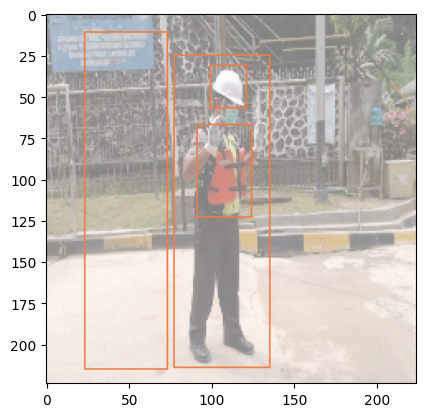

In [8]:
model.testing()

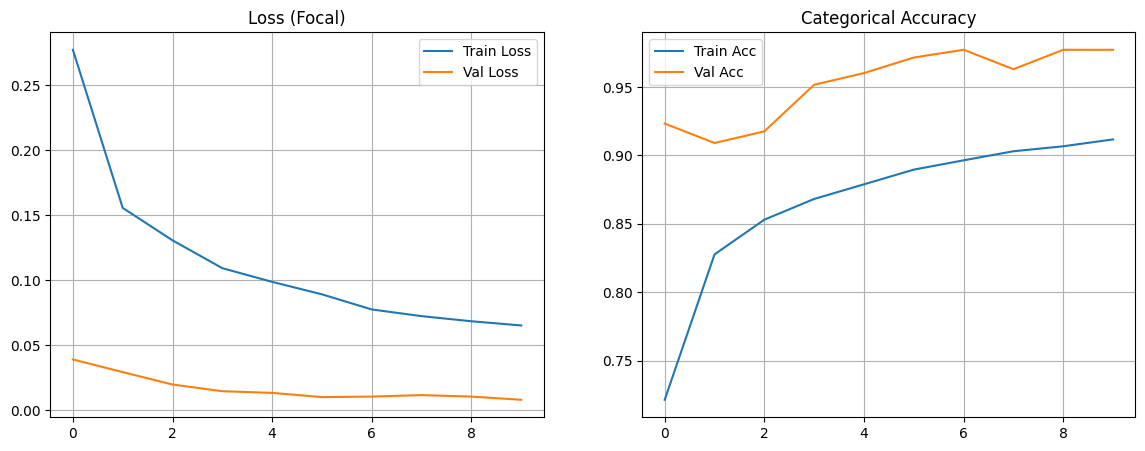

Эпоха 10 завершена.
Train - Loss: 0.0653, Acc: 0.9117
Valid - Loss: 0.0081, Acc: 0.9773
Нет улучшения (Best: 0.9773)

Эпоха 11/30
Обучение: .................................................

KeyboardInterrupt: 

In [9]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output


train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
best_val_acc = 0.0
epochs = 30

print("Начинаем обучение (Softmax, 6 классов)...")

for epoch in range(epochs):
    start_time = time.time()
    
    train_loss_sum = 0.0
    train_steps = 0
    
    print(f"\nЭпоха {epoch + 1}/{epochs}")
    print("Обучение: ", end="")
    
    for step, (image, bounding_boxes, classes) in enumerate(dataset):
        loss_val, (gt, pred) = model.train_step(image, bounding_boxes, classes)
        
        if tf.reduce_all(tf.equal(loss_val, 0.0)) and tf.shape(gt)[0] == 1:
             continue
            
        train_acc_metric.update_state(gt, pred)
        train_loss_sum += float(loss_val)
        train_steps += 1
        
        if step % 50 == 0: print(".", end="")
            
    avg_train_loss = train_loss_sum / train_steps if train_steps > 0 else 0
    avg_train_acc = float(train_acc_metric.result())
    train_acc_metric.reset_state()

    print("\nВалидация: ", end="")
    val_loss_sum = 0.0
    val_steps = 0
    
    for image_val, bbox_val, classes_val in valid_dataset:
        pred_probs_val_raw = model.predict(image_val, bbox_val)
        pred_probs_val = tf.reshape(pred_probs_val_raw, [-1, 6]) 
        
        classes_flat = tf.reshape(classes_val, [-1])
        bbox_flat = tf.reshape(bbox_val, [-1, 4])
        
        x1_v, y1_v = bbox_flat[:, 0], bbox_flat[:, 1]
        x2_v, y2_v = bbox_flat[:, 2], bbox_flat[:, 3]
        
        valid_mask = (x2_v > x1_v) & (y2_v > y1_v)
        if not tf.reduce_any(valid_mask): continue
            
        valid_classes = tf.boolean_mask(classes_flat, valid_mask)
        valid_pred = tf.boolean_mask(pred_probs_val, valid_mask)
        
        valid_classes = tf.cast(valid_classes, tf.int32)
        
        valid_classes_mapped = tf.where(valid_classes == -1, 0, valid_classes)
      
        gt_onehot_val = tf.one_hot(valid_classes_mapped, depth=6)
        
        val_acc_metric.update_state(gt_onehot_val, valid_pred)
        
        batch_loss_val = model.crossentropy(gt_onehot_val, valid_pred)
        val_loss_sum += float(batch_loss_val)
        val_steps += 1
    
    avg_val_loss = val_loss_sum / val_steps if val_steps > 0 else 0
    avg_val_acc = float(val_acc_metric.result())
    val_acc_metric.reset_state()

    history['loss'].append(avg_train_loss)
    history['accuracy'].append(avg_train_acc)
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(avg_val_acc)
    
    clear_output(wait=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(history['loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title('Loss (Focal)')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history['accuracy'], label='Train Acc')
    ax2.plot(history['val_accuracy'], label='Val Acc')
    ax2.set_title('Categorical Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()
    
    print(f"Эпоха {epoch + 1} завершена.")
    print(f"Train - Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f}")
    print(f"Valid - Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}")
    
    # === СОХРАНЕНИЕ ===
    if avg_val_acc > best_val_acc:
        print(f"Улучшение! {best_val_acc:.4f} -> {avg_val_acc:.4f}")
        best_val_acc = avg_val_acc
        model.network.save('best_classifier_weights.h5')
        if len(model.base_network.trainable_variables) > 0:
            model.base_network.save('best_base_weights.h5')
    else:
        print(f"Нет улучшения (Best: {best_val_acc:.4f})")


In [15]:
model.network.save('models/classifier.h5')
model.base_network.save('models/base_classifier.h5')

In [11]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report


val_acc_metric = tf.metrics.CategoricalAccuracy()


def categorical_focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha_weights=None):
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    
    cross_entropy = -y_true * tf.math.log(y_pred)
    
    
    weight = tf.pow(1 - y_pred, gamma) * cross_entropy
    
  
    
    return tf.reduce_mean(tf.reduce_sum(weight, axis=-1))

val_loss_sum = 0.0
val_steps = 0
buffer_true = []
buffer_pred = []

print("Запуск валидации (SOFTMAX 6-CLASS FIX)...")


for step, (images, bounding_boxes, classes) in enumerate(valid_dataset):
    
    if len(images.shape) == 3:
        images = tf.expand_dims(images, axis=0)
        bounding_boxes = tf.expand_dims(bounding_boxes, axis=0)
        classes = tf.expand_dims(classes, axis=0)
        
    batch_size = tf.shape(images)[0]
    
    for i in range(batch_size):
        img_single = images[i]
        bbox_single = bounding_boxes[i]
        cls_single = classes[i]
        
        try:
            pred_probs = model.predict(img_single, bbox_single)
        except Exception as e:
            print(f"Error at step {step}: {e}")
            continue

        classes_flat = tf.reshape(cls_single, [-1])
        bbox_flat = tf.reshape(bbox_single, [-1, 4])
        
        x1, y1 = bbox_flat[:, 0], bbox_flat[:, 1]
        x2, y2 = bbox_flat[:, 2], bbox_flat[:, 3]
        
        valid_mask = (x2 > x1) & (y2 > y1)
        if not tf.reduce_any(valid_mask):
            continue
            
        valid_classes = tf.boolean_mask(classes_flat, valid_mask)
        valid_pred = tf.boolean_mask(pred_probs, valid_mask) # [M, 6]
        

        valid_classes_int = tf.cast(valid_classes, tf.int32)
        valid_classes_mapped = tf.where(valid_classes_int == -1, 0, valid_classes_int)
        
        gt_onehot = tf.one_hot(valid_classes_mapped, depth=6) 
     
        batch_loss = model.crossentropy(gt_onehot, valid_pred) 
        val_loss_sum += float(batch_loss)
        
        val_acc_metric.update_state(gt_onehot, valid_pred)
        val_steps += 1
        

        y_pred_class = tf.argmax(valid_pred, axis=1) # 0..5
        
        y_true_class = valid_classes_mapped # 0..5
        
        buffer_true.extend(y_true_class.numpy())
        buffer_pred.extend(y_pred_class.numpy())



avg_loss = val_loss_sum / val_steps if val_steps > 0 else 0
avg_acc = float(val_acc_metric.result())

print("\n" + "="*40)
print("FINAL VALIDATION RESULTS (SOFTMAX)")
print("="*40)
print(f"Loss:           {avg_loss:.4f}")
print(f"Acc (Categorical): {avg_acc:.4f}")
print("-" * 40)

if len(buffer_true) > 0:
    unique_labels = np.unique(np.concatenate([buffer_true, buffer_pred]))
    target_names = []
    
    
    possible_names = ["Background", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5"]
    
    labels_to_report = []
    names_to_report = []
    
    for label in unique_labels:
        if 0 <= label < len(possible_names):
            labels_to_report.append(label)
            names_to_report.append(possible_names[label])
            
    print("\nDetailed Metrics (Sklearn):")
    print(classification_report(
        buffer_true, 
        buffer_pred, 
        labels=labels_to_report, 
        target_names=names_to_report, 
        zero_division=0
    ))
else:
    print("No valid data collected for metrics.")

val_acc_metric.reset_state()


Запуск валидации (SOFTMAX 6-CLASS FIX)...

FINAL VALIDATION RESULTS (SOFTMAX)
Loss:           0.0076
Acc (Categorical): 0.9858
----------------------------------------

Detailed Metrics (Sklearn):
              precision    recall  f1-score   support

  Background       1.00      0.96      0.98        82
     Class 1       1.00      0.97      0.99        72
     Class 2       0.89      1.00      0.94        17
     Class 3       1.00      1.00      1.00         1
     Class 4       0.97      1.00      0.98        87
     Class 5       1.00      1.00      1.00        93

    accuracy                           0.99       352
   macro avg       0.98      0.99      0.98       352
weighted avg       0.99      0.99      0.99       352



Сбор данных для PR-кривой...


C:\Users\Ильяс\AppData\Local\Temp\ipykernel_33144\3214805266.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes) # Палитра


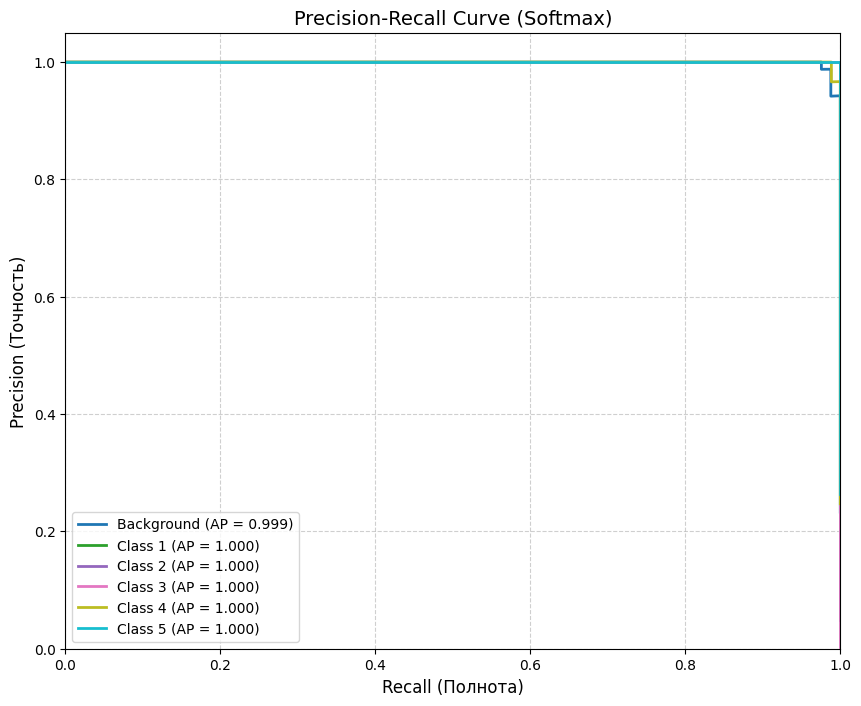


Mean Average Precision (mAP): 0.9998


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize


y_true_all = []   
y_scores_all = []

print("Сбор данных для PR-кривой...")

for step, (images, bounding_boxes, classes) in enumerate(valid_dataset):
    if len(images.shape) == 3:
        images = tf.expand_dims(images, axis=0)
        bounding_boxes = tf.expand_dims(bounding_boxes, axis=0)
        classes = tf.expand_dims(classes, axis=0)
        
    batch_size = tf.shape(images)[0]
    
    for i in range(batch_size):
        try:
            pred_probs = model.predict(images[i], bounding_boxes[i]) # [N, 6]
        except:
            continue
            
        bbox_flat = tf.reshape(bounding_boxes[i], [-1, 4])
        classes_flat = tf.reshape(classes[i], [-1])
        
        x1, y1 = bbox_flat[:, 0], bbox_flat[:, 1]
        x2, y2 = bbox_flat[:, 2], bbox_flat[:, 3]
        valid_mask = (x2 > x1) & (y2 > y1)
        
        if not tf.reduce_any(valid_mask): continue
            
        valid_classes = tf.boolean_mask(classes_flat, valid_mask)
        valid_scores = tf.boolean_mask(pred_probs, valid_mask)
        
        valid_classes_int = tf.cast(valid_classes, tf.int32)
        valid_classes_mapped = tf.where(valid_classes_int == -1, 0, valid_classes_int)
        
        y_true_all.extend(valid_classes_mapped.numpy())
        y_scores_all.extend(valid_scores.numpy())

y_true_all = np.array(y_true_all)
y_scores_all = np.array(y_scores_all)


n_classes = 6
class_names = ["Background", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5"]


y_true_binary = label_binarize(y_true_all, classes=range(n_classes))

precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_binary[:, i], y_scores_all[:, i])
    average_precision[i] = average_precision_score(y_true_binary[:, i], y_scores_all[:, i])


plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes) # Палитра

for i in range(n_classes):
    if np.sum(y_true_binary[:, i]) == 0:
        print(f"Класс {class_names[i]} отсутствует в валидации, пропускаем.")
        continue
        
    plt.plot(recall[i], precision[i], lw=2, color=colors(i),
             label=f'{class_names[i]} (AP = {average_precision[i]:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Полнота)', fontsize=12)
plt.ylabel('Precision (Точность)', fontsize=12)
plt.title('Precision-Recall Curve (Softmax)', fontsize=14)
plt.legend(loc="lower left", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


mAP = np.mean(list(average_precision.values()))
print(f"\nMean Average Precision (mAP): {mAP:.4f}")


Сбор данных для ROC-кривой...


C:\Users\Ильяс\AppData\Local\Temp\ipykernel_33144\269492791.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


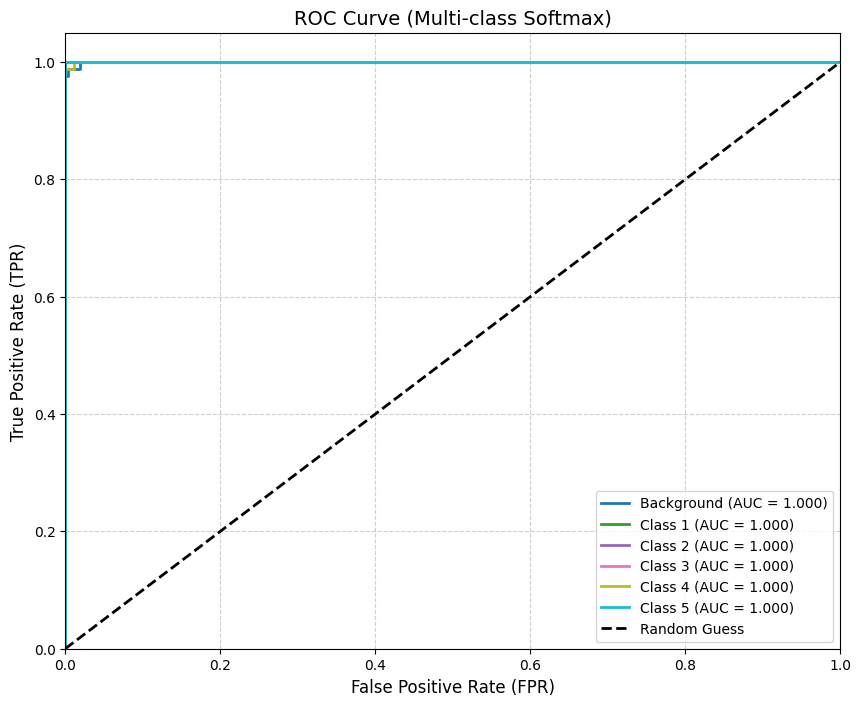


Macro Average AUC: 0.9999


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


y_true_all = []   
y_scores_all = []

print("Сбор данных для ROC-кривой...")

for step, (images, bounding_boxes, classes) in enumerate(valid_dataset):
    if len(images.shape) == 3:
        images = tf.expand_dims(images, axis=0)
        bounding_boxes = tf.expand_dims(bounding_boxes, axis=0)
        classes = tf.expand_dims(classes, axis=0)
        
    batch_size = tf.shape(images)[0]
    
    for i in range(batch_size):
        try:
            pred_probs = model.predict(images[i], bounding_boxes[i]) # [N, 6]
        except:
            continue
            
        bbox_flat = tf.reshape(bounding_boxes[i], [-1, 4])
        classes_flat = tf.reshape(classes[i], [-1])
        
        x1, y1 = bbox_flat[:, 0], bbox_flat[:, 1]
        x2, y2 = bbox_flat[:, 2], bbox_flat[:, 3]
        valid_mask = (x2 > x1) & (y2 > y1)
        
        if not tf.reduce_any(valid_mask): continue
            
        valid_classes = tf.boolean_mask(classes_flat, valid_mask)
        valid_scores = tf.boolean_mask(pred_probs, valid_mask)
        
        valid_classes_int = tf.cast(valid_classes, tf.int32)
        valid_classes_mapped = tf.where(valid_classes_int == -1, 0, valid_classes_int)
        
        y_true_all.extend(valid_classes_mapped.numpy())
        y_scores_all.extend(valid_scores.numpy())

y_true_all = np.array(y_true_all)
y_scores_all = np.array(y_scores_all)


n_classes = 6
class_names = ["Background", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5"]

y_true_binary = label_binarize(y_true_all, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    if np.sum(y_true_binary[:, i]) == 0:
        continue
        
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_scores_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    if i not in fpr: continue 
    
    plt.plot(fpr[i], tpr[i], lw=2, color=colors(i),
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve (Multi-class Softmax)', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

if len(roc_auc) > 0:
    print(f"\nMacro Average AUC: {np.mean(list(roc_auc.values())):.4f}")
